Epoch 10/100 - Loss: 0.0769 - Acc: 0.9583
Epoch 20/100 - Loss: 0.0635 - Acc: 0.9667
Epoch 30/100 - Loss: 0.0587 - Acc: 0.9667
Epoch 40/100 - Loss: 0.0542 - Acc: 0.9833
Epoch 50/100 - Loss: 0.0538 - Acc: 0.9917
Epoch 60/100 - Loss: 0.0415 - Acc: 0.9833
Epoch 70/100 - Loss: 0.0402 - Acc: 0.9833
Epoch 80/100 - Loss: 0.0400 - Acc: 0.9833
Epoch 90/100 - Loss: 0.0400 - Acc: 0.9833
Epoch 100/100 - Loss: 0.0348 - Acc: 0.9917

Test Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       0.90      1.00      0.95         9
   virginica       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30





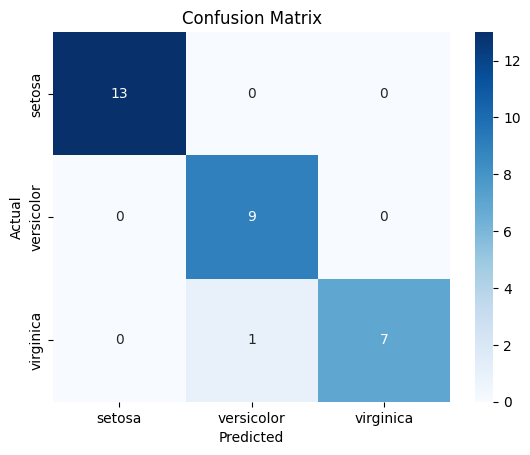

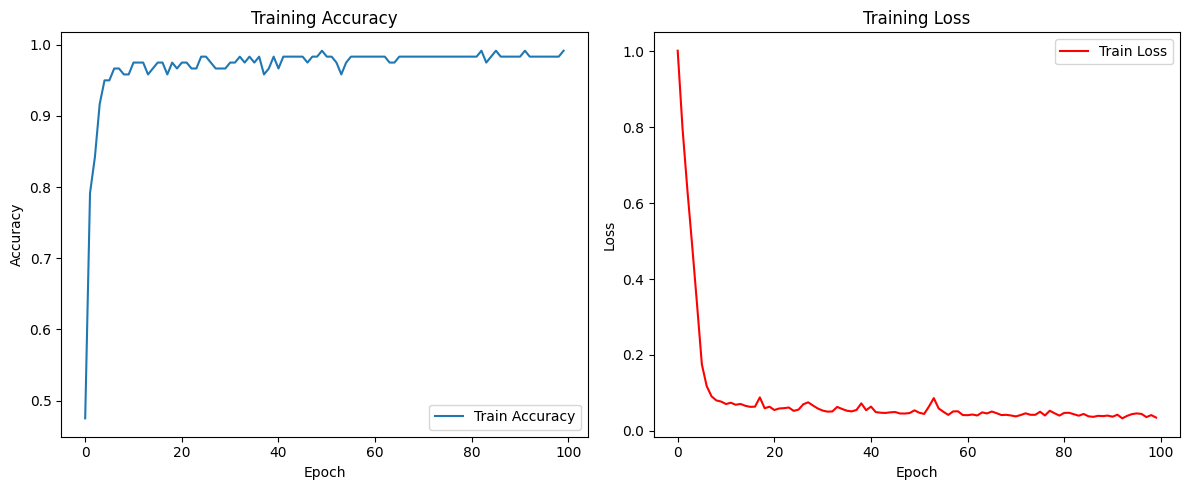

In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

# Load and preprocess dataset
url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
df = pd.read_csv(url)

le = LabelEncoder()
df['species'] = le.fit_transform(df['species'])  # setosa=0, versicolor=1, virginica=2

X = df.drop('species', axis=1).values
y = df['species'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8)

# Define the model
class IrisMLP(nn.Module):
    def __init__(self):
        super(IrisMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 3)
        )

    def forward(self, x):
        return self.model(x)

model = IrisMLP()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
train_losses = []
train_accuracies = []
epochs = 100

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Loss: {train_losses[-1]:.4f} - Acc: {train_accuracies[-1]:.4f}")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"\nTest Accuracy: {accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))
print("\n")
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\n")

# Plot training metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.tight_layout()
plt.show()
